In [1]:
import pandas as pd
import numpy as np

# utils
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# nlp
import spacy
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bambr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv('Phishing_Email.csv')

# dropping nulls
data = data.dropna()

# specific doc that is incredible large
data = data.drop(index=12500)

# unecessary column
data = data.drop(columns=['Unnamed: 0'])

# adding binary representation of target
data['binary_target'] = data['Email Type'].map({'Phishing Email': 1, 'Safe Email': 0})

In [3]:
df = data.copy()

In [4]:
# splitting dataset for futher evaluation
features_to_use = ['Email Text']
target =  'binary_target'
X, y = df[features_to_use].copy(), df[target].copy()

In [5]:
# Preprocessing

class PreProcessEmail(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.nlp_ = spacy.load('en_core_web_sm')

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        cleaned_emails = X['Email Text'].str.replace('\n', ' ').str.replace(r'\s\\', '')
        nlp_docs = [self.nlp_(doc) for doc in cleaned_emails]
        return nlp_docs

class GetTokenStatistics(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        tokens_statistics = [
            (
                len(doc), # how many tokens
                len([token for token in doc if token.is_alpha]), # how many words
                len([token for token in doc if (token.is_alpha) and (len(wn.synsets(token.text)) > 0)]), # how many recognizable words
                len([token for token in doc if token.is_punct]), # how many special chars tokens
                len([token for token in doc if token.like_email]), # how many email tokens
                len([token for token in doc if token.like_url]) # how many url tokens
            ) for doc in X
        ]
        
        tokens_stats_df = pd.DataFrame(tokens_statistics, columns=['tokens_len', 'tokens_words', 'tokens_real_words', 'tokens_special', 'tokens_email', 'tokens_url'])
        
        # augmenting base dataframe
        new_X = pd.DataFrame()
        new_X['tokens_len'] = tokens_stats_df['tokens_len'].values
        new_X['tokens_words_perc'] = np.where(tokens_stats_df['tokens_len'] > 0, (tokens_stats_df['tokens_words'] / tokens_stats_df['tokens_len']), 0)
        new_X['tokens_real_words_perc'] = (tokens_stats_df['tokens_real_words'] / tokens_stats_df['tokens_words']).values
        new_X['tokens_special_perc'] = (tokens_stats_df['tokens_special'] / tokens_stats_df['tokens_len']).values
        new_X['has_email'] = (tokens_stats_df['tokens_email'] > 0).values
        new_X['has_url'] = (tokens_stats_df['tokens_url'] > 0).values

        self.new_X_ = new_X.fillna(0)

        return new_X

    def get_feature_names_out(self, X, y=None):
        return self.new_X_.columns

class NMFTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.pipeline = Pipeline([('tf-idf', TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')), ('nmf', NMF(n_components=6, random_state=42))])

    def _preprocess_email(self, doc):
        return " ".join([token.lemma_ for token in doc if (not token.is_stop) and (token.is_alpha) and (len(token) > 2)])
    
    def fit(self, X, y=None):

        processed_emails = [self._preprocess_email(doc) for doc in X]
        
        self.pipeline.fit(processed_emails)
        return self

    def transform(self, X, y=None):
        processed_emails = [self._preprocess_email(doc) for doc in X]
        
        nmf_topics = self.pipeline.transform(processed_emails)
        
        new_X = pd.DataFrame()
        new_X['email_text'] = [doc.text for doc in X]
        new_X['topic'] = [doc.argmax() for doc in nmf_topics]

        self.new_X_ = new_X

        return new_X

    def get_feature_names_out(self, X, y=None):
        return self.new_X_.columns

class DataFrameFeatureUnion(TransformerMixin, BaseEstimator):
    def __init__(self, transformer_list):
        self.transformer_list = transformer_list

    def fit(self, X, y=None):
        for (_, transformer) in self.transformer_list:
            transformer.fit(X, y)
        return self

    def transform(self, X):
        X_transformed = pd.concat(
            [transformer.transform(X) for _, transformer in self.transformer_list],
            axis=1
        )
        return X_transformed

    def get_feature_names_out(self):
        feature_names = []
        for name, transformer in self.transformer_list:
            if hasattr(transformer, 'get_feature_names_out'):
                feature_names.extend(transformer.get_feature_names_out())
            else:
                feature_names.extend(transformer.columns)
        return feature_names


preprocess = ColumnTransformer([
    ('text_feature', Pipeline([
            ('tf-idf', TfidfVectorizer(stop_words='english')),
            ('svd', TruncatedSVD(n_components=10))
        ]), 'email_text'),
    ('ohe', OneHotEncoder(), ['topic']),
    ('scaler', MinMaxScaler(), ['tokens_len']),
], remainder='passthrough')

pipeline = Pipeline([
    ('nlp_docs', PreProcessEmail()),
    ('nlp_features', DataFrameFeatureUnion([
        ('GetTokenStatistics', GetTokenStatistics()),
        ('TopicAnalysis', NMFTransformer())
    ])),
    ('preprocess', preprocess),
    ('value_imputer', SimpleImputer(strategy='constant', fill_value=0))
])


In [6]:
pipeline

Pipeline(steps=[('nlp_docs', PreProcessEmail()),
                ('nlp_features',
                 DataFrameFeatureUnion(transformer_list=[('GetTokenStatistics',
                                                          GetTokenStatistics()),
                                                         ('TopicAnalysis',
                                                          NMFTransformer())])),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text_feature',
                                                  Pipeline(steps=[('tf-idf',
                                                                   TfidfVectorizer(stop_words='english')),
                                                                  ('svd',
                                                                   TruncatedSVD(n_components=10))]),
                                                  'email_text'),
                                                 ('ohe', OneHotEncoder(),
                                                  ['topic']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['tokens_len'])])),
                ('value_imputer',
                 SimpleImputer(fill_value=0, strategy='constant'))])

- **PreProcessEmail**: Clean some metacharacters from email text and return a list of tokenized spacy docs
- **GetTokenStatistics**: Get token statistics:
     - how many tokens are in the doc
     - percentage of word tokens in the doc
     - percentage of recognizable words (words found in wordnet dictionary) by the total of word tokens in the doc
     - percentage of special chars tokens in the doc
     - boolean if has one or more email in the doc
     - boolean if has one or more url in the doc
- **TopicAnalysis**: run a NMF model to categorize into 6 topics (this model is demonstrated in "EDA and Feature Engineering" notebook
- **text_feature**: run a TF-IDF Vectorizer aiming to get the most relevant words and then run a Truncated SVD to reduce the dimensionality to 10 components, this is done to prevent from the curse of dimensionality when training a predictive model
- **ohe**: one-hot encode the topic feature, as it's an categorical feature
- **scaler**: scale the 'tokens_len' feature as it's the only numerical feature that isn't scaled into the 0-1 range

In [7]:
processed_df = pipeline.fit_transform(X)

In [8]:
processed_pd = pd.DataFrame(processed_df)
processed_pd = processed_pd.fillna(0)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(processed_pd, y, test_size=0.2, random_state=42)

Accuracy scores for each fold:  [0.95214106 0.94008439 0.95254237 0.93187553 0.94542401 0.94358974
 0.94557823 0.95798319 0.93728814 0.94157494]
Mean accuracy: 0.94
Standard deviation of accuracy: 0.01


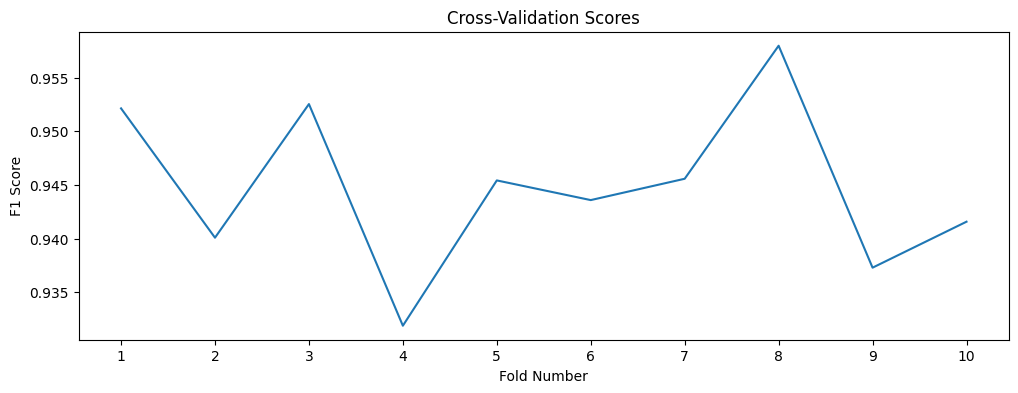

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
clf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Perform cross-validation
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1')

# Print the results
print("Accuracy scores for each fold: ", scores)
print("Mean accuracy: {:.2f}".format(np.mean(scores)))
print("Standard deviation of accuracy: {:.2f}".format(np.std(scores)))

# Plotting the results
fig, ax = plt.subplots(figsize=(12, 4))

ax = sns.lineplot(x=range(1, len(scores)+1), y=scores)
_ = ax.set_title('Cross-Validation Scores')
_ = ax.set_xlabel('Fold Number')
_ = ax.set_ylabel('F1 Score')
_ = ax.set_xticks(range(1, len(scores) + 1))


In [10]:
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [11]:
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix

In [12]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:, 1]

In [13]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2241
           1       0.94      0.96      0.95      1486

    accuracy                           0.96      3727
   macro avg       0.96      0.96      0.96      3727
weighted avg       0.96      0.96      0.96      3727



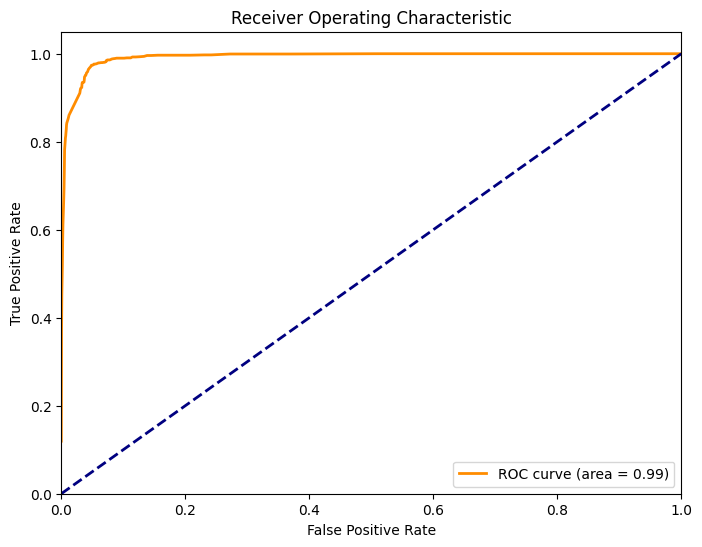

In [14]:
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 6))

ax = sns.lineplot(x=fpr, y=tpr, color='darkorange', lw=2, label='ROC curve (area = %.2f)' % roc_auc, ax=ax)
ax = sns.lineplot(x=[0, 1], y=[0, 1], color='navy', lw=2, linestyle='--', ax=ax)
_ = ax.set_xlim([0.0, 1.0])
_ = ax.set_ylim([0.0, 1.05])
_ = ax.set_xlabel('False Positive Rate')
_ = ax.set_ylabel('True Positive Rate')
_ = ax.set_title('Receiver Operating Characteristic')
_ = ax.legend(loc="lower right")


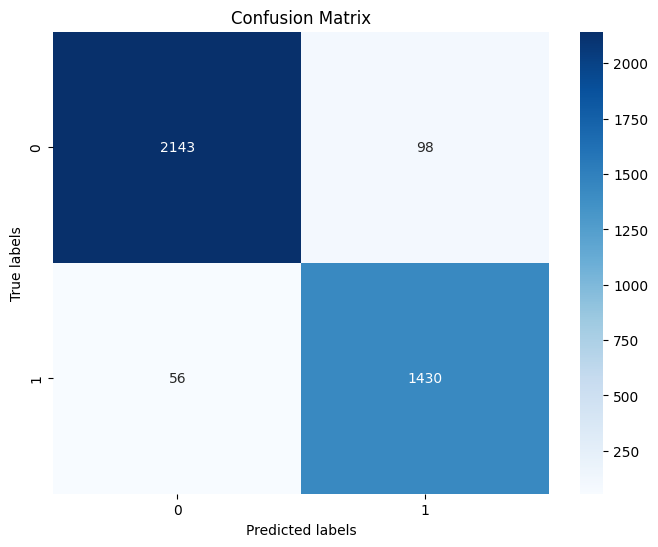

In [15]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))

ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
_ = ax.set_xlabel('Predicted labels')
_ = ax.set_ylabel('True labels')
_ = ax.set_title('Confusion Matrix')


In [16]:
pipeline.steps.append(('model', RandomForestClassifier(random_state=42, class_weight='balanced')))

In [17]:
pipeline

Pipeline(steps=[('nlp_docs', PreProcessEmail()),
                ('nlp_features',
                 DataFrameFeatureUnion(transformer_list=[('GetTokenStatistics',
                                                          GetTokenStatistics()),
                                                         ('TopicAnalysis',
                                                          NMFTransformer())])),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text_feature',
                                                  Pipeline(steps=[('tf-idf',
                                                                   TfidfVectorizer(stop_words='english')),
                                                                  ('svd',
                                                                   TruncatedSVD(n_components=10))]),
                                                  'email_text'),
                                                 ('ohe', OneHotEncoder(),
                                                  ['topic']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['tokens_len'])])),
                ('value_imputer',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [18]:
import pickle

In [19]:
pipeline.fit(X, y)

Pipeline(steps=[('nlp_docs', PreProcessEmail()),
                ('nlp_features',
                 DataFrameFeatureUnion(transformer_list=[('GetTokenStatistics',
                                                          GetTokenStatistics()),
                                                         ('TopicAnalysis',
                                                          NMFTransformer())])),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text_feature',
                                                  Pipeline(steps=[('tf-idf',
                                                                   TfidfVectorizer(stop_words='english')),
                                                                  ('svd',
                                                                   TruncatedSVD(n_components=10))]),
                                                  'email_text'),
                                                 ('ohe', OneHotEncoder(),
                                                  ['topic']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['tokens_len'])])),
                ('value_imputer',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [20]:
with open('phishing_detector.pkl', 'wb') as file:
    pickle.dump(pipeline, file)